In [1]:
import sys,os, glob, time, astropy, warnings, pickle
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import *
from astropy.io import fits
import sklearn.mixture.gaussian_mixture as GMM
from builtins import zip
### LSST dependencies 
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils.mafUtils import radec2pix
from lsst.sims.maf.utils import m52snr, astrom_precision
sys.path.append('/home/idies/LSST_OpSim/Scripts_NBs/')
from opsimUtils import *

In [2]:
def sigma_slope_arr(x, sigmay):
    w = 1./np.array(sigmay)**2
    denom = np.sum(x)*np.sum(w*x**2,axis=1)-np.sum(w*x,axis=1)**2
    denom[np.where(denom <= 0)]=np.nan
    denom[np.where(denom > 0)] = np.sqrt(np.sum(w)*denom[np.where(denom > 0)]**-1 )
    return denom

In [38]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook. 
         raise Exception('Please provide your username!  See the top of the notebook.') 

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/' 
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username) 

if not os.path.exists(os.path.abspath(outDir)): 
     os.mkdir(os.path.abspath(outDir)) 
dbRuns = show_opsims(dbDir) 
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [4]:
sqlconstraint ='note not like  "DD%" '
slicer = slicers.HealpixSlicer(nside=16) 

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


# Proper Motion - True Novelties

We simulate objects with weird proper motion to analyse the ability of LSST to detect weird object given different strategies.
We'll do it using three approach:
- Toy model: How well we can discriminate structures?
- transients: How well we can detect trasients which lc is influenced by the motion?
- unusual motion: How well we can distriminate usual from not usual objects?

## Sagitarius A Simulation

for the first point we will use a specific dataset and simulate it at different distancies and opacities to analyse to what limit we will be able to recostruct components and with what precision 

In [5]:
class reducedPM(BaseMetric): 
    
        def readfile(self, filename='', colsname=['']): 
            if 'csv' in filename: 
                #print('reading {}'.format(filename)) 
                data = pd.read_csv(filename, header=0, names = colsname ) 
            elif 'fits' in filename: 
                 #print('reading {}'.format(filename)) 
                hdul = fits.open(filename) 
                data = hdul[1].data 
            elif ['txt', 'dat'] in filename: 
                #print('reading {}'.format(filename)) 
                data = {k:[] for k in colsname} 
                f = open(filename) 
                righe = f.readlines() 
                for line in righe: 
                    line.split() 
                    for i, k in enumerate(colsname): 
                        data[k].append(float(line[i]))                 
            elif 'json'in filename: 
                print('not implemented to read .json extention') 
            return data 
        
        def __init__(self, filename = 'data.csv', snr_lim=5,mode=None, MagIterLim=[0,1,1], surveyduration=10,
                      metricName='reducedPM',m5Col='fiveSigmaDepth',real_data= True, 
                      mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True,**kwargs): 
            self.mjdCol = mjdCol 
            self.m5Col = m5Col 
            self.seeingCol = seeingCol 
            self.filterCol = filterCol 
            self.snr_lim = snr_lim 
            self.filename = filename  
            self.dataout = dataout 
            self.mode = mode 
            self.MagIterLim = MagIterLim 
            self.surveyduration = surveyduration 
            
            self.real_data = real_data
             # to have as output all the simulated observed data set dataout=True, otherwise the relative error for  
             # each helpix is estimated 
            if self.dataout: 
                super(reducedPM, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol, 'night' ],metricDtype='object', units='', metricName=metricName, 
                                                      **kwargs) 
            else: 
                super(reducedPM, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol, 'night' ], 
                                                            units='', metricDtype='float',metricName=metricName, 
                                                             **kwargs) 
            if self.real_data:    
                colsname=['RA', 'DEC','g','g-r','Hg','PM_OUT','deltaX'] 
                self.data = self.readfile(self.filename, colsname)
                self.data['MAG']=self.data['g']
            else:
                colsname=['MAG','MODE','d','PM','PM_OUT']
                self.data = self.readfile(self.filename, colsname)
            data_sag93 = fits.open('sa93.all.fits')
            table = data_sag93[1].data    
            mu_sag= np.transpose([table['MUX'],table['MUY']])
            self.mu_sag=mu_sag
        def run(self, dataSlice, slicePoint=None): 
            pm = np.array(self.data['PM_OUT'])
            mag = np.array(self.data['MAG'])
            obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
            
            deltamag= np.arange(self.MagIterLim[0],self.MagIterLim[1],self.MagIterLim[2])
            out = {}
            for dm in deltamag: 
                
                    if self.mode == 'distance': 
                        pmnew= pm/(10**(dm/5)) 
                    elif self.mode == 'density': 
                        pmnew= pm 
                    else: 
                        print('##### ERROR: the metric is not implemented for this mode.')
                        
                    mjd = dataSlice[self.mjdCol][obs]
                    flt = dataSlice[self.filterCol][obs]
                    if ('g' in flt) and ('r' in flt):
                        
                        # select objects above the limit magnitude threshold 
                        snr = m52snr(mag[:, np.newaxis],dataSlice[self.m5Col][obs])
                        row, col =np.where(snr>self.snr_lim)
                        precis = astrom_precision(dataSlice[self.seeingCol][obs], snr)
                        sigmapm=sigma_slope_arr(dataSlice[self.mjdCol][obs], precis)*365.25*1e3
                           
                        #select the objects which displacement can be detected
                        Times = list(mjd)
                        DeltaTs = []
                        while len(Times)>1:
                            i=0
                            for d in range(len(Times)-1):
                                DeltaTs.append(Times[d]-Times[d+1])
                            Times.remove(Times[0])
                        dt_pm = 0.05*np.median(dataSlice[self.seeingCol])/pmnew[np.unique(row)]
                        selection = np.where((dt_pm>DeltaTs[0]) & (dt_pm<DeltaTs[-1]))
                        
                        if self.real_data:
                            Hg = np.array(self.data['Hg'])[selection]
                            gr = np.array(self.data['g-r'])[selection] 
                        else:
                            colsname=['RA', 'DEC','MAG','g-r','Hg','PM_OUT','deltaX'] 
                            color_dist = self.readfile('data.csv', colsname)
                            gr = np.random.choice(color_dist['g-r'],size= np.size(selection))
                            Hg = mag[selection]+5*np.log10(pm[selection])-10
                        
                        g= mag+dm 
                        sigmaHg = np.sqrt((g[selection]/m52snr(g[selection],np.median(dataSlice[self.m5Col])))**(2)+ (4.715*sigmapm[selection]/pmnew[selection])**2) 
                        sigmag = np.sqrt((g[selection]/m52snr(g[selection],np.median(dataSlice[self.m5Col])))**2+((g[selection]-gr)/m52snr((g[selection]-gr),np.median(dataSlice[self.m5Col])))**2)
                        err_ellipse = np.pi*sigmaHg*sigmag
                        n = len(pmnew[selection])/len(pmnew)
                        pa= np.random.uniform(0,2*np.pi,len(pmnew[selection]))
                        n_components = np.arange(1, 10)
                        pm_alpha = pmnew[selection]*np.sin(pa)
                        pm_delta = pmnew[selection]*np.cos(pa)
                        mu = np.transpose(np.array([pm_alpha,pm_delta]))
                        Phi_c = np.exp(((mu[:,0]-0.42)**2+(mu[:,1]+2.66)**2)/2)
                        gamma=((0.42-np.median(self.mu_sag[:,0]))*(-2.66-np.median(self.mu_sag[:,0])))
                        Phi_f=np.exp(((mu[:,0]-np.median(self.mu_sag[:,0]))**2-(mu[:,0]-np.median(self.mu_sag[:,0]))*(mu[:,1]-np.median(self.mu_sag[:,1]))+(mu[:,1]-np.median(self.mu_sag[:,1]))**2)/2/(1-gamma))
                        P=Phi_c/Phi_f
                        idx_c =np.where(P>1)
                        
                        try:
                            models = [GMM.GaussianMixture(n, covariance_type='full', random_state=0).fit(mu[idx_c]) for n in n_components]
                            BIC = [m.bic(mu[idx_c]) for m in models]
                            k_cluster=n_components[np.where(BIC==np.min(BIC))][0]    
                        except:
                            k_cluster = 0
                        out[dm] = {'CI':np.median(err_ellipse), 'k': k_cluster, 'PM':mu}  
            if self.dataout: 
                return out  
            else:
                if ('g' in flt) and ('r' in flt):
                    res = out[dm]['k']
                    return res 

In [6]:
metricCI= reducedPM(metricName='CI',filename='data.csv',snr_lim=5,mode='distance', surveyduration = 2, 
                    MagIterLim=[1,2,1],m5Col='fiveSigmaDepth',mjdCol='observationStartMJD',filterCol='filter', 
                    seeingCol='seeingFwhmGeom',dataout=False)
metricSkyCI = metricBundles.MetricBundle(metricCI,slicer,sqlconstraint)

In [7]:
bundleDict={'CI': metricSkyCI}

## Proper motion - unusual object 

We produced a sample of 6 Gyr stars in a magnitude range 15-25 mag that move as prescripted by the litterature, based on the velocity distribution funciton of the Galaxy in Binney et al 2009, and compared it to the same sample of stars that move with velocity from a different velocity distribution funcion.

We estimated, of those objects, the likelihood probability to be detected.

In [8]:
class LSPMmetric(BaseMetric): 
        def __init__(self, metricName='LSPMmetric',f='g',surveyduration=10,snr_lim=5,mag_lim=[17,25],percentiles=[2.5,97.5,50], 
                    U=np.arange(-100,100,25),V=np.arange(-100,100,25),W=np.arange(-100,100,25),unusual='uniform',m5Col='fiveSigmaDepth',  
                    mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom', nexp= 1,dataout=False, 
                    **kwargs):
            self.mjdCol = mjdCol 
            self.m5Col = m5Col 
            self.seeingCol = seeingCol 
            self.filterCol= filterCol 
            self.surveyduration =surveyduration 
            self.percentiles = percentiles
            self.snr_lim = snr_lim 
            self.mag_lim = mag_lim
            self.f = f 
            self.nexp = nexp 
            self.U=U 
            self.V=V 
            self.W=W 
            self.unusual=unusual
            self.dataout = dataout 
             # to have as output all the simulated observed data set dataout=True, otherwise the relative error for  
             # each helpix is estimated 
            sim = pd.read_csv('hyperstar_uniform.csv', usecols=['MAG','MODE','d','PM','PM_out'])
            self.simobj = sim
            if self.dataout: 
                super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol, 'night' ],metricDtype='object', units='', metricName=metricName, 
                                                      **kwargs) 
            else: 
                super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol, 'night'], 
                                                            units='Proper Motion relative error', metricName=metricName, 
                                                             **kwargs) 
          
            np.seterr(over='ignore',invalid='ignore')
         # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
            
        def position_selection(self,R,z):
            # costants
            ab = 1 #kpc
            ah = 1.9 #kpc
            alphab = 1.8
            alphah = 1.63
            betah =2.17
            rb = 1.9 #Kpc
            qb = 0.6
            qh = 0.8
            z0 = 0.3 #kpc
            z1 = 1 #kpc
            Rd = 3.2 #kpc
            rho0b = 0.3*10**(-9) #Mskpc^-3
            rho0h = 0.27*10**(-9) #Mskpc^-3
            sigma = 300*10**(-6) #Mskpc^-2
            alpha1 = 0.5
            # parametes
            mb = np.sqrt(R**2+z**2/qb**2)
            mh = np.sqrt(R**2+z**2/qh**2)
            alpha0 =1-alpha1
            
            rhoh = rho0h*(mh/ah)**alphah*(1+mh/ah)**(alphah-betah)
            rhob = rho0b*(mb/ab)**(-alphab)*np.exp(-mb/rb)
            rhod = sigma*np.exp(R/Rd)*(alpha0/(2*z0)*np.exp(-np.absolute(z)/z0)+alpha1/(2*z1)*np.exp(-np.absolute(z)/z1))
            densities = np.array([rhoh,rhob,rhod])/np.sum(np.array([rhoh,rhob,rhod]))
            mode = np.array(['H','B','D'])
            idx = np.where(densities == np.amax(densities))
            return mode[idx]
        
        def DF(self,V_matrix,mode,R,z):                
            if mode == 'H':
                v = np.sqrt(V_matrix[0,:]**2+V_matrix[1,:]**2+V_matrix[2,:]**2)
                vesc = 575 #km/s
                vsun =187.5 #km/s
                N=1.003
                P=4*N/vsun/np.sqrt(np.pi)*(v/vesc)**2*np.exp(-v**2/vsun)
            if mode == 'B': 
                v = np.sqrt(V_matrix[0,:]**2+V_matrix[1,:]**2+V_matrix[2,:]**2)
                disp = 140 #km/s
                P = np.exp(-v**2/2/disp**2)/np.sqrt(np.pi)/disp
            if mode == 'D':
                k= 0.25
                q =0.45
                Rd = 3.2 #kpc
                sigmaz0= 19 #km/s
                sigmar0= 33.5 #km/s
                beta = 0.33
                L0 = 10 #km/s
                sigma = 300*10**(-6) #Ms/kpc**2
            
                # parameters
                v = V_matrix[2,:]
                Jz = v**2/2 + v**2/2*np.log(R**2+z**2/0.8**2) 
                Ar = k * Jz /np.exp(2*q*(120 - R)/Rd)/sigmar0
                Az =  k * Jz /np.exp(2*q*(120 - R)/Rd)/sigmaz0                
                P = v**2/Jz*sigma*(1+np.tanh(R*v/L0))*np.exp(-k*Jz/(sigmar0*np.exp(2*q*(120 - R)/Rd))**2)/(np.pi*k*sigmar0*np.exp(2*q*(120 - R)/Rd))
                
            return P
          
                           
        def run(self, dataSlice, slicePoint=None): 
            np.random.seed(2500) 
            obs = np.where((dataSlice['filter']==self.f) & (dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)) 
            d = self.simobj['d']
            M = np.array(self.simobj['MAG'])
            mu = np.array(self.simobj['PM'])
            muf = np.array(self.simobj['PM_out'])
            mjd = dataSlice[self.mjdCol][obs]
            if len(dataSlice[self.m5Col][obs])>2: 
                
                # select objects above the limit magnitude threshold 
                snr = m52snr(M[:, np.newaxis],dataSlice[self.m5Col][obs])
                row, col =np.where(snr>self.snr_lim)
                precis = astrom_precision(dataSlice[self.seeingCol][obs], snr)
                sigmapm=sigma_slope_arr(dataSlice[self.mjdCol][obs], precis)*365.25*1e3

                #select the objects which displacement can be detected
                Times = list(mjd)
                DeltaTs = []
                while len(Times)>1:
                    i=0
                    for d in range(len(Times)-1):
                        DeltaTs.append(Times[d]-Times[d+1])
                    Times.remove(Times[0])
                dt_pm = 0.05*np.median(dataSlice[self.seeingCol])/muf[np.unique(row)]
                selection = np.where((dt_pm>DeltaTs[0]) & (dt_pm<DeltaTs[-1]))

                if np.size(selection)>0:
                    p_min,p_max,p_mean = self.percentiles[0],self.percentiles[1],self.percentiles[2]
                    mu_min,mu_max, mu_mean = np.percentile(np.array(mu)[selection],[p_min,p_max,p_mean])
                    OK = np.isfinite(np.array(muf)[selection])
                    pm = muf[selection][OK]
                    s = sigmapm[selection][OK]
                    muf_index = np.where((pm < mu_min)| (pm >mu_max))
                    ii = (pm[muf_index]+ s[muf_index]<mu_min)|(pm[muf_index]+ s[muf_index]>mu_max)
                    kk = (pm[muf_index]- s[muf_index]<mu_min)|(pm[muf_index]- s[muf_index]>mu_max)
                    u = ii & kk
                    unusual = np.size(muf_index)
                    if unusual == 0:
                        res = 0
                    else:
                        res = len(np.where(u==True))/unusual
                 
                    fieldRA = np.mean(dataSlice['fieldRA']) 
                    fieldDec = np.mean(dataSlice['fieldDec'])
                    #dic = {'detected': res,
                    #        'pixID': radec2pix(nside=16, ra=np.radians(fieldRA), dec=np.radians(fieldDec))}  
                    dic= {'detected': res,
                            'pixID': radec2pix(nside=16, ra=np.radians(fieldRA), dec=np.radians(fieldDec)),
                            'PM': np.array(mu)[selection], 
                            'PM_OUT': pm}
                    if self.dataout:
                        return dic 
                    else: 
                        return res 
                

In [9]:
metricLS = LSPMmetric(metricName= 'LS',f='g',m5Col='fiveSigmaDepth',
           mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',percentiles=[2.5,97.5,50],
           surveyduration = 2,dataout=False)
metricSkyLS = metricBundles.MetricBundle(metricLS,slicer,sqlconstraint)

In [10]:
bundleDict.update({'like': metricSkyLS})

In [ ]:
def Likelihood(self, variables, ty= ''): 
            if ty == 'usual': 
                pmname = 'PM'
                pmnamex = 'PMx' 
                pmnamey = 'PMy'
            elif ty == 'unusual': 
                pmname = 'PM_out' 
                pmnamex = 'PMx_out' 
                pmnamey = 'PMy_out' 
            else: 
                 print('you need to define the proper motion object type [usual or unusual]') 
            
            # pm dist conditioned to the mag and the dt
            B = np.where(variables['MODE']=='B')[0]
            H = np.where(variables['MODE']=='H')[0]
            D = np.where(variables['MODE']=='D')[0]
            
            if len(B)>0:
                Lb, binsb = np.histogram(variables[pmname][B],bins=np.linspace(np.amin(variables[pmname][B]),np.amax(variables[pmname][B]),np.size(variables['MODE'])+1))
                pi_b = len(B)/len(variables['MODE'])
            else:
                Lb = np.zeros(np.size(variables['MODE']))
                pi_b=0
            if len(D)>0:
                Ld, binsd = np.histogram(variables[pmname][D],bins=np.linspace(np.amin(variables[pmname][D]),np.amax(variables[pmname][D]),np.size(variables['MODE'])+1))
                pi_d = len(D)/len(variables['MODE'])
            else:
                Ld = np.zeros(np.size(variables['MODE']))
                pi_d=0
            if len(H)>0:
                Lh, binsh = np.histogram(variables[pmname][H],bins=np.linspace(np.amin(variables[pmname][H]),np.amax(variables[pmname][H]),np.size(variables['MODE'])+1))
                pi_h = len(H)/len(variables['MODE'])
            else:
                Lh = np.zeros(np.size(variables['MODE']))
                pi_h=0
            
            Lk = np.array([pi_b*Lb,pi_d*Ld,pi_h*Lh])
            Pm = np.exp(-0.5*variables['snr']**2*((variables[pmnamex]*variables['d']*variables['t']-variables['x'])**2+(variables[pmnamey]*variables['d']*variables['t']-variables['y'])**2)/(variables['FWHM']**2*0.67**2*variables['d']**2*variables['t']**2))*variables['snr']/(np.sqrt(2*np.pi)*variables['FWHM']*0.67)
            L = np.sum(Lk, axis=0)/len(Lk) *  Pm/np.sum(Pm) 
            return L 

## Proper Motion - Transients

Using the unusual stellar sample we analysed the possibility to detect trasient which has maximum at the simulated magnitude and the vary in the time of the motion.

In [11]:
class TransienPM(BaseMetric): 
     #    Generate a population of transient objects and see what is its proper motion  , 
    def __init__(self, metricName='TransienPM', f='g', snr_lim=5,m5Col='fiveSigmaDepth',  
                  mjdCol='observationStartMJD',filterCol='filter',seeingCol='seeingFwhmGeom', surveyduration=10, **kwargs): 
            self.mjdCol = mjdCol 
            self.seeingCol= seeingCol 
            self.m5Col = m5Col 
            self.filterCol = filterCol 
            self.snr_lim = snr_lim 
            self.f = f
            self.surveyduration = surveyduration  
            sim = pd.read_csv('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/True Novelities/simulation_pm.csv', usecols=['MAG','MODE','d','PM','PM_out'])
            self.simobj = sim
            super(TransienPM, self).__init__(col=[self.mjdCol, self.m5Col,self.seeingCol, self.filterCol], 
                                                       units='Fraction Detected', 
                                                       metricName=metricName, **kwargs) 
      
         # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics) 
      
    def lightCurve(self, t, t0, peak, duration, slope): 
     #      A simple top-hat light curve., 
     #         
     #        Parameters , 
     #        ---------- , 
     #        t : array , 
     #            Times to generate lightcurve points (mjd) , 
     #        t0 : float , 
     #            Initial time (mjd) , 
     #        m_r_0 : float , 
     #            initial r-band brightness (mags) , 
             lightcurve = np.zeros(np.size(t), dtype=float) + 99. 
     # Select only times in the lightcurve duration window , 
             good = np.where( (t >= t0) & (t <= t0+duration) ) 
             lightcurve[good] = peak + slope*(t[good]-t0) 
             return lightcurve 
      
    def run(self,  dataSlice, slicePoint=None): 
            pm = np.array(self.simobj['PM_out'])
            mag = np.array(self.simobj['MAG'])
            obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
            np.random.seed(5000)
            mjd = dataSlice[self.mjdCol][obs]
            flt = dataSlice[self.filterCol][obs]
            if (self.f in flt):
                snr = m52snr(mag[:, np.newaxis],dataSlice[self.m5Col][obs])
                row, col =np.where(snr>self.snr_lim)
                precis = astrom_precision(dataSlice[self.seeingCol][obs], snr)
                sigmapm=sigma_slope_arr(dataSlice[self.mjdCol][obs], precis)*365.25*1e3

                #select the objects which displacement can be detected
                Times = list(mjd)
                DeltaTs = []
                while len(Times)>1:
                    i=0
                    for d in range(len(Times)-1):
                        DeltaTs.append(Times[d]-Times[d+1])
                    Times.remove(Times[0])
                dt_pm = 0.05*np.median(dataSlice[self.seeingCol])/pm[np.unique(row)]
                selection = np.where((dt_pm>DeltaTs[0]) & (dt_pm<DeltaTs[-1]))

                objRate = 0.7 # how many go off per day
                nObj=np.size(pm[selection])
                m0s = mag[selection]
                t = dataSlice[self.mjdCol][obs] - dataSlice[self.mjdCol].min() 
                detected = 0 
         # Loop though each generated transient and decide if it was detected , 
         # This could be a more complicated piece of code, for example demanding  , 
         # A color measurement in a night. , 

                for i,t0 in enumerate(np.random.uniform(0,self.surveyduration,nObj)): 
                    duration =dt_pm[selection][i]
                    slope = np.random.uniform(-3,3) 
                    lc = self.lightCurve(t, t0, m0s[i],duration, slope) 
                    good = m52snr(lc,dataSlice[self.m5Col][obs])> self.snr_lim 
                    detectTest = dataSlice[self.m5Col][obs] - lc 
                    if detectTest.max() > 0 and len(good)>2: 
                         detected += 1 
                 # Return the fraction of transients detected , 
                if float(nObj) == 0:
                    A = np.inf 
                else: 
                    A=float(nObj) 
                    res = float(np.sum(detected))/A            
                    #print('detected fraction:{}'.format(res)) 
                    return res
            #else:
                #print('no detected pm for transients')
                #continue

In [12]:
metricTPM = TransienPM( snr_lim=5,  surveyduration=2, f='g',
                    metricName='TPM',m5Col='fiveSigmaDepth', 
                    mjdCol='observationStartMJD',filterCol='filter', 
                    seeingCol='seeingFwhmGeom')
metricSkyTPM = metricBundles.MetricBundle(metricTPM,slicer,sqlconstraint)

In [40]:
for db in dbRuns:
    if 'baseline' in db:
        print(db)

baseline_2snaps_v1.5_10yrs
baseline_v1.5_10yrs
baseline_samefilt_v1.5_10yrs


In [41]:
bundleDict.update({'TPM': metricSkyTPM})
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in  enumerate(dbRuns):
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSkyLS.setRunName(run)
    metricSkyCI.setRunName(run)
    metricSkyTPM.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print( '--- {:.2f} minutes ---\n'.format((time.time() - start_time)/60))
    print('####################\n')

##############

N_1, baseline_samefilt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['seeingFwhmGeom', 'night', 'fieldRA', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldDec']
Found 2205031 visits
Running:  ['CI', 'like', 'TPM']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 20.14 minutes ---

####################



In [42]:
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
# get a dictionary of resultDb from given directory 
resultDbs2 = getResultsDbs(outDir) 

# the following line will be useful if you did not run MAF on all 75 opsims 
runNames = list(resultDbs2.keys()) 
bundleDicts = {} 
for runName in dbRuns: #dbRuns:# metric_runs: 
     bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)
for k in dbRuns:
    print(bundleDicts[k].keys())

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
dict_keys([(1, 'CI'), (2, 'LS'), (3, 'TPM')])


In [43]:
col = ['TPM', 'LS', 'CI']
mafs = pd.DataFrame(index=col, columns=dbRuns)
for db in dbRuns:
    bmetric = [(t[0],t[1]) for t in bundleDicts[db].keys()]
    i, metric = zip(*bmetric)
    i,metric = np.array(i), np.array(metric)
    for c in col:
        ind = np.where(metric==c)
        arr = bundleDicts[db][(i[ind][0],c)].metricValues.data
        arr_ = arr[arr!= None]
        if isinstance(arr_[0], dict):
            mafs[db][c]=pd.DataFrame.from_records(arr_)
        else:
            mafs[db][c]=bundleDicts[db][(i[ind][0],c)].metricValues[np.where(bundleDicts[db][(i[ind][0],c)].metricValues.mask==False)]

In [52]:
import pickle
with open('Mafs_sim.p','wb') as fout:
    pickle.dump(mafs,fout)

# Figure of Merit

In [75]:
Foms

,TPM,LS,CI
dcr_nham1_ugri_v1.5_10yrs,0.331578,0.0604299,0.713151
rolling_mod6_sdf_0.20_v1.5_10yrs,0.319475,0.0866998,0.68945
wfd_depth_scale0.95_noddf_v1.5_10yrs,0.338043,0.0860958,0.768697
u60_v1.5_10yrs,0.338963,0.0619404,0.685644
footprint_stuck_rollingv1.5_10yrs,0.313869,0.0861642,0.830601
...,...,...,...
bulges_cadence_bs_v1.5_10yrs,0.326713,0.0933444,0.742737
third_obs_pt30v1.5_10yrs,0.324238,0.0813658,0.732443
wfd_depth_scale0.99_v1.5_10yrs,0.317798,0.0816471,0.777667
filterdist_indx5_v1.5_10yrs,0.352773,0.078081,0.764175


In [72]:
Foms =pd.DataFrame(index= dbRuns, columns= col)
for key in dbRuns:
    for c in col:
        Foms[c][key]= np.nanmean(mafs[key][c].data)
idx=np.argsort(np.sum(Foms, axis=1)) 
idx=idx[::-1]

In [73]:
Foms.to_csv('Score_foms.csv')

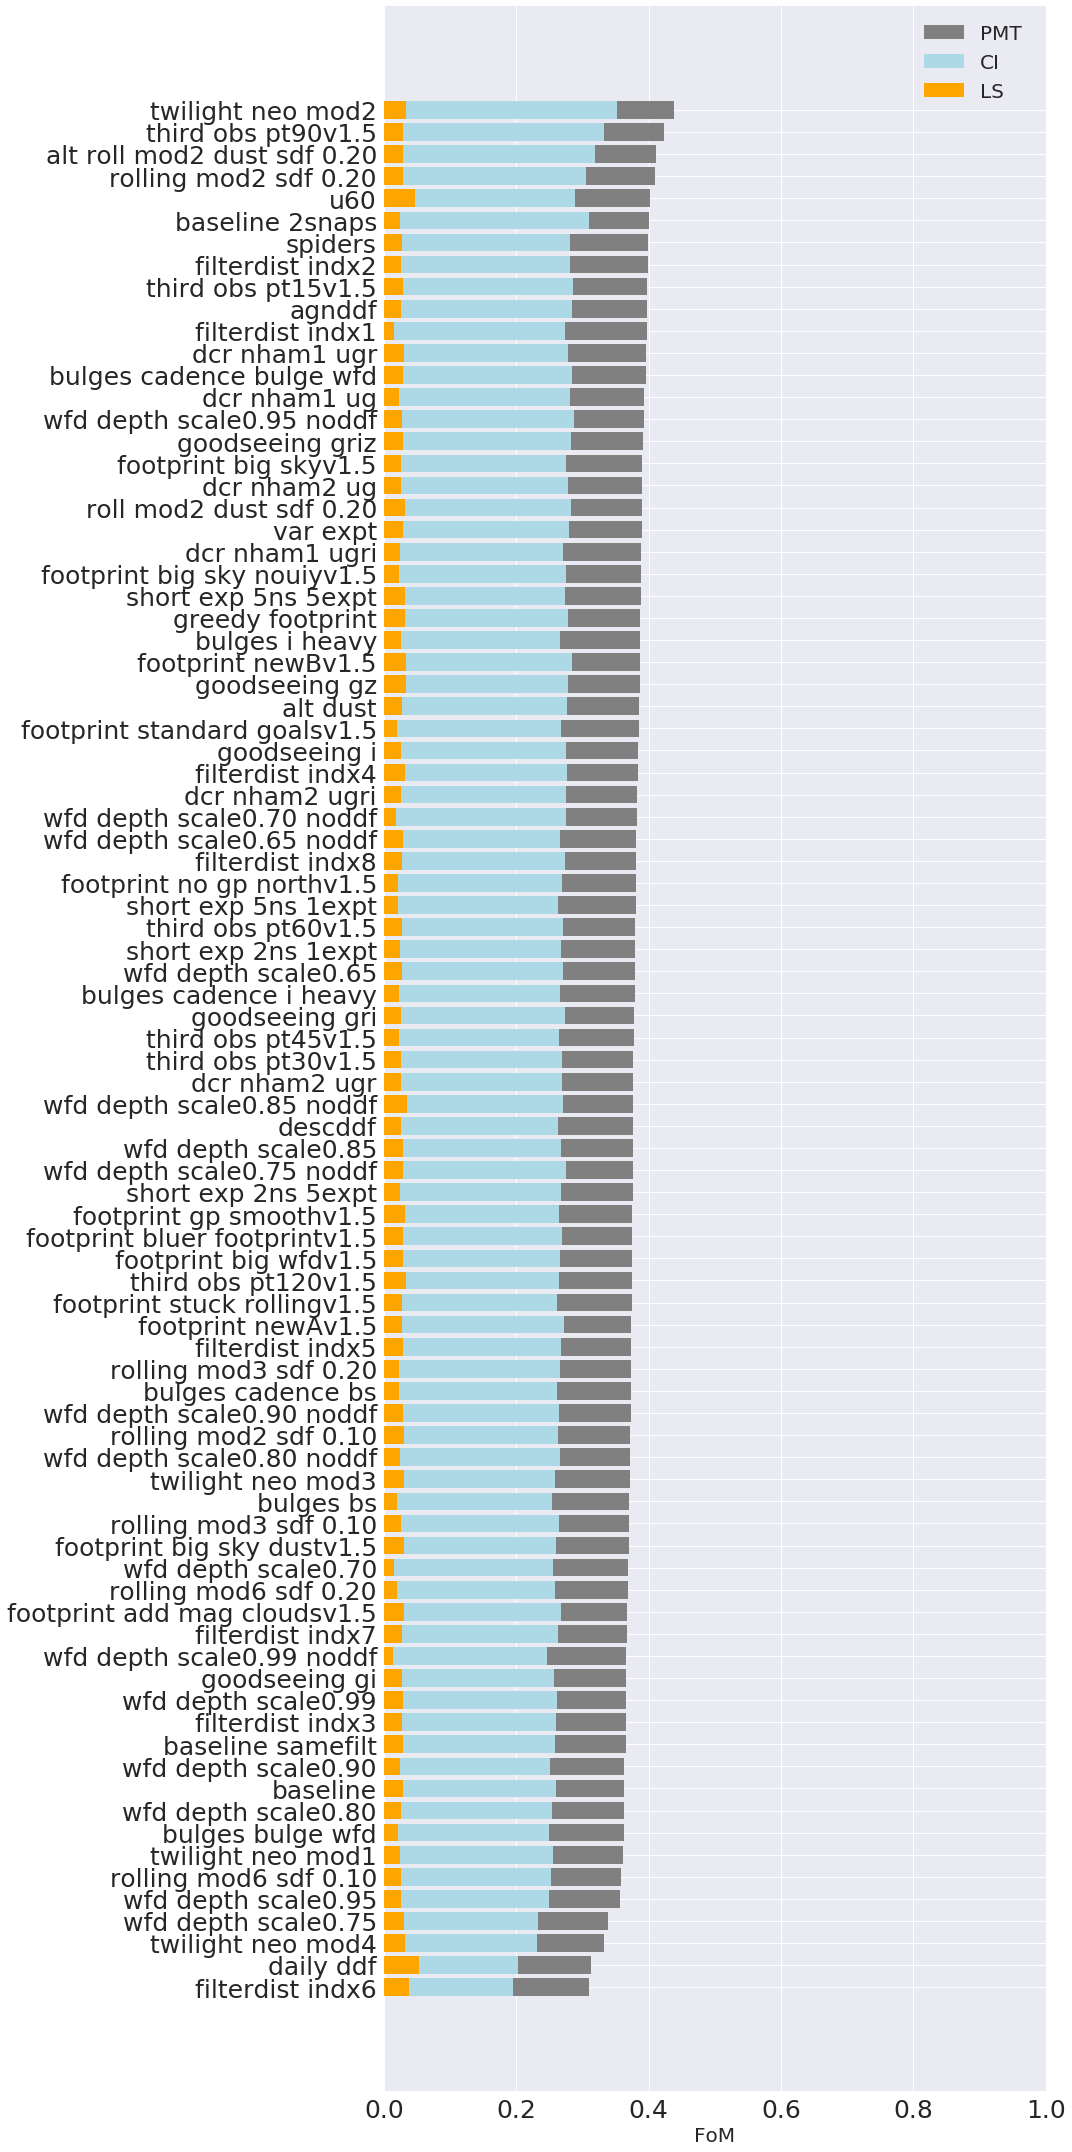

In [74]:
name_tick=[] 
for key in dbRuns:#bundleDicts.keys(): 
#if 'noddf' in key: 
#    continue 
#else: 
    n= key.split('_') 
    if 'v1.5' in n: 
        n.remove('v1.5') 
    else: 
        word=[] 
        for s in n[-2]: 
            word.append(s) 
            word[0].replace('v','') 
            word[0].replace('1','')  
            word[0].replace('.','')  
            word[0].replace('5','')  
        sub ='' 
        n[-2]= sub.join(word) 
    n.remove('10yrs') 
    s=' ' 
    name_tick.append(s.join(n))
plt.style.use('seaborn') 
plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=25) 
fig, ax = plt.subplots(figsize=(15,30)) 
y_pos = np.arange(len(name_tick)) 
ax.barh(y_pos,(Foms['LS'][idx]+Foms['CI'][idx]+Foms['TPM'][idx])/3, align='center',color='grey',label='PMT ') 
ax.barh(y_pos,(Foms['LS'][idx]+Foms['CI'][idx])/3, align='center',color='lightblue' ,label='CI') 
ax.barh(y_pos,Foms['LS'][idx]/3, align='center', color= 'orange',label='LS') 
ax.set_xlim([0,1]) 
ax.set_yticks(y_pos[idx]) 
ax.set_yticklabels(name_tick, size=25) 
ax.invert_yaxis()  # labels read top-to-bottom 
ax.set_xlabel('FoM', size=20) 
ax.legend(bbox_to_anchor=(1,1),fontsize=20) 
plt.tight_layout() 
plt.savefig('FOM_2yrs_v1p5.pdf')